In [2]:
## import sys
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
import scipy.ndimage
from astropy import units as u

from scalessim.DFT import *
from scalessim.binning import *
from scalessim.phasescreen import *
from scalessim.pupil import *
from scalessim.io import *
from scalessim.focal_plane import *
from scalessim.targs import *
from scalessim.base import *
from scalessim.helpers import *

## Configure your H2RG

Load in h2rg configuration file 

In [3]:
import configparser
from detector import nghxrg as ng

config = configparser.ConfigParser()
config.read('h2rg.ini')

arg_detector = {}
arg_detector.update(read_ini(config['Defined']))

ng_h2rg = ng.HXRGNoise(verbose=False,
                        wind_mode='WINDOW',
                        naxis1=1024, naxis2=1024,
                        pca0_file='./detector/lmircam_pca0.fits')


Define some reasonable noise parameters

In [4]:
rd_noise=arg_detector['readout_noise_cds']*1.   # White read noise per integration
pedestal=arg_detector['pedestal']*1.   # DC pedestal drift rms
c_pink=arg_detector['c_pink']*1.     # Correlated pink noise
u_pink=arg_detector['u_pink']*1.     # Uncorrelated pink noise
acn=arg_detector['acn']*1.        # Correlated ACN
pca0_amp=arg_detector['pca0_amp']*1.   # Amplitude of PCA zero "picture frame" noise

#arg_detector 

## Configure SCALES mode

Read in SCALES config file for H2RG

In [5]:
config.read('scales_h2rg.ini')
arg_spaxel = {}
arg_spaxel.update(read_ini(config['Defined']))
arg_spaxel.update(read_ini(config['Derived']))
arg_spaxel.update(read_ini(config['User']))

#arg_spaxel

## Read in Keck pupil

In [6]:
keck = fits.getdata('keckpupil.fits')
keck = scipy.ndimage.zoom(keck, 10, order=0)
pupil = Pupil()
pupil.pupil = keck

## Filtered phase screen for toy AO correction

Can set screen1 to zeros to leave this out

In [7]:
screen1 = np.zeros(pupil.pupil.shape)

0 1.9 micron
1 1.91 micron
2 1.92 micron
3 1.93 micron
4 1.94 micron
5 1.95 micron
6 1.96 micron
7 1.97 micron
8 1.98 micron
9 1.99 micron
10 2.0 micron
11 2.01 micron
12 2.02 micron
13 2.03 micron
14 2.04 micron
15 2.05 micron
16 2.06 micron
17 2.07 micron
18 2.08 micron
19 2.09 micron
20 2.1 micron
21 2.11 micron
22 2.12 micron
23 2.13 micron
24 2.1399999999999997 micron
25 2.15 micron
26 2.16 micron
27 2.17 micron
28 2.1799999999999997 micron
29 2.19 micron
30 2.1999999999999997 micron
31 2.21 micron
32 2.2199999999999998 micron
33 2.23 micron
34 2.2399999999999998 micron
35 2.25 micron
36 2.26 micron
37 2.27 micron
38 2.28 micron
39 2.29 micron
40 2.3 micron
41 2.31 micron
42 2.32 micron
43 2.33 micron
44 2.34 micron
45 2.35 micron
46 2.36 micron
47 2.37 micron
48 2.38 micron
49 2.3899999999999997 micron
50 2.4 micron
51 2.41 micron
52 2.42 micron
53 2.4299999999999997 micron
54 2.44 micron
55 2.45 micron
56 2.46 micron
57 2.4699999999999998 micron
58 2.48 micron
59 2.4899999999999

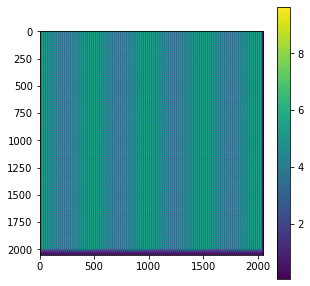

0 1.9 micron
1 1.91 micron
2 1.92 micron
3 1.93 micron
4 1.94 micron
5 1.95 micron
6 1.96 micron
7 1.97 micron
8 1.98 micron
9 1.99 micron
10 2.0 micron
11 2.01 micron
12 2.02 micron
13 2.03 micron
14 2.04 micron
15 2.05 micron
16 2.06 micron
17 2.07 micron
18 2.08 micron
19 2.09 micron
20 2.1 micron
21 2.11 micron
22 2.12 micron
23 2.13 micron
24 2.1399999999999997 micron
25 2.15 micron
26 2.16 micron
27 2.17 micron
28 2.1799999999999997 micron
29 2.19 micron
30 2.1999999999999997 micron
31 2.21 micron
32 2.2199999999999998 micron
33 2.23 micron
34 2.2399999999999998 micron
35 2.25 micron
36 2.26 micron
37 2.27 micron
38 2.28 micron
39 2.29 micron
40 2.3 micron
41 2.31 micron
42 2.32 micron
43 2.33 micron
44 2.34 micron
45 2.35 micron
46 2.36 micron
47 2.37 micron
48 2.38 micron
49 2.3899999999999997 micron
50 2.4 micron
51 2.41 micron
52 2.42 micron
53 2.4299999999999997 micron
54 2.44 micron
55 2.45 micron
56 2.46 micron
57 2.4699999999999998 micron
58 2.48 micron
59 2.4899999999999

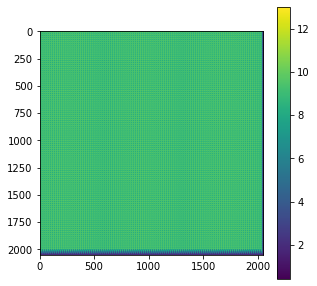

In [8]:
modes = [[2.0,4.0],[4.5,5.2]]
for wavs in modes:
    wav_min,wav_max = wavs
    arg_spaxel['min_wavelength'] = wav_min #minimum wavelength in microns
    arg_spaxel['max_wavelength'] = wav_max #maximum wavelength in microns
    
    lens = Lenslet(arg_spaxel)
    lens.get_shifts()
    lens.make_trace(phys=True,disp=True,verbose=True)
    
    nspax = arg_spaxel['no_spaxel']
    nlam = lens.trace.shape[0]

    keck_cube = np.zeros((nlam, nspax, nspax))
    mag1 = magn(lens.lmin)
    mag2 = magn(lens.lmax)

    psf_file = 'keck_psf_cube_'+str(lens.lmin)+'_'+str(lens.lmax)+'_n'+str(nlam)+'.fits'
    if os.path.isfile(psf_file)==False:
        for i, mag in enumerate(np.linspace(mag1, mag2, nlam)):
            W = DFT_matrix(1600, mag)
            A = pupil.pupil * np.exp(1.j * screen1)
            out = abs(W.dot(A).dot(W))**2
            out /= np.sum(out, axis=(0,1))
            keck_cube[i] = frebin(out, (108, 108))
        fits.writeto(psf_file,np.array(keck_cube),clobber=True)
    else: keck_cube = pyfits.getdata(psf_file)

    vapor = 1 #PWV in mm
    airmass = 1 
    skybg = SkyBG(vapor,airmass)
    skytrans = SkyTrans(vapor,airmass)
    atmodisp = AtmoDispersion(90,20,600)

    telAO_emissivities = [0.4]
    telAO_temps = [285*u.K]
    scales_trans = [0.4]
    inst = InstTransEm(telAO_emissivities, telAO_temps, scales_trans)
    qe = QE()
    filt = Filter(lmin=lens.lmin,lmax=lens.lmax,fkw='asahi')
    dit = 1 ###integration time in seconds
    
    ####organize all these and pass to focal_plane 
    args_new = {'Lenslet_object':lens,
            'SkyBG':skybg,
            'SkyTrans':skytrans,
            'InstTransEm':inst,
            'Filter':filt,
            'QE':qe}
    fp = FocalPlane(args_new)
    
    raw, bg_star_truth = fp.get_fp(dit*u.s,return_full=True,PSF=keck_cube,return_phots=True)
    rawfile = 'skyonly_asahi_disp_'+str(wav_min)+'_'+str(wav_max)+'_phot_s.fits'
    pyfits.writeto(rawfile,np.array(raw),clobber=True)
    rawfile = 'skyonly_asahi_disp_'+str(wav_min)+'_'+str(wav_max)+'_e_s.fits'
    pyfits.writeto(rawfile,np.array(raw*0.8),clobber=True)


    f = plt.figure(figsize=(5,5))
    plt.imshow(raw**0.25)
    plt.colorbar()
    plt.show()